# TESS Background data

This notebook shows how to use `BackgroundCube` to get TESS Full Frame Images (FFI) scatter light component and Earth/Moon angles as pixel maps for every camera/ccd in the instrument.

This data could be used to train a machine learning model or used directly to correct the scatter light contribution in TESS cutouts. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# basic imports
import os
import numpy as np
from tess_backml import BackgroundCube
from tess_backml.utils import pooling_2d
import matplotlib.pyplot as plt

# increase animation frame limits
import matplotlib
matplotlib.rcParams["animation.embed_limit"] = 2**128

In [3]:
# define sector/camera/ccd
sector = 2
camera = 1
ccd = 1
binsize = 16

We initialize the object with a specific Sectopr/Camera/CCD, an image bin size, and a method for downsizing (default if 'binning')

In [4]:
bkg_data = BackgroundCube(
    sector=sector, camera=camera, ccd=ccd, img_bin=binsize, downsize="binning"
)
print(bkg_data)

TESS FFI Background object (Sector, Camera, CCD, N times): 2, 1, 1, 1245


Compute the binned scatter light cube which does:
- Finds the darkest frame in the sector to build a star mask and a saturated pixel mask
- Adds a strap mask
- Pulls the FFI flux data from the cloud
- Downsize the image by doing median 16x16 binning, masking out stars, straps, and saturated pixels
- The resulting scatter light cube has shape [nt, 128, 128]

Computing sector darkest frames...


INFO:tess_backml:Computing sector darkest frames...


Computing star mask...


INFO:tess_backml:Computing star mask...


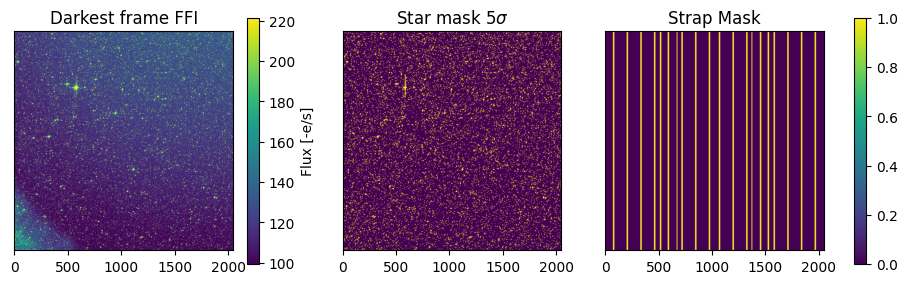

Getting FFI flux cube...


INFO:tess_backml:Getting FFI flux cube...


Computing average static scene from darkes frames...


INFO:tess_backml:Computing average static scene from darkes frames...


Iterating frames:  51%|█████     | 629/1245 [14:10<14:04,  1.37s/it]

In [ ]:
bkg_data.get_scatter_light_cube(frames=None, mask_straps=True, plot=True)

We can animate the scatter light cube for visualization

In [6]:
bkg_data.animate_data(data="sl", save=False, step=10);

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Now we compute the Earth/Moon vector maps:
- We pull the Earth/Moon distance, azimuth, and elevation angles from the engineering files. This values a w.r.t. each camera's boresight and changes for each frame in the sector.
Using trigonometric rules, we compute these values for each pixel in the downsized grid [nt, 128, 128].
- If `ang_size == True` then the Earth/Moon distances are changed to angular size.

In [ ]:
bkg_data.get_vector_maps(ang_size=True)

We can inspect these maps for a single frame

In [ ]:
tdx = 500

fig, ax = plt.subplots(2, 3, figsize=(9,6), sharex=True, sharey=True)

fig.suptitle(
    f"Sector {sector} Camera {camera} CCD {ccd} | "
    f"Frame {tdx} Time {bkg_data.time[tdx]:.3f}"
)
ax[0, 0].imshow(bkg_data.earth_maps["alt"][tdx], origin="lower")
ax[0, 1].imshow(bkg_data.earth_maps["az"][tdx], origin="lower")
ax[0, 2].imshow(bkg_data.earth_maps["dist"][tdx], origin="lower")

ax[0, 0].set_title("Earth Altitude Angle")
ax[0, 1].set_title("Earth Azimuth Angle")
ax[0, 2].set_title("Earth Angular Size")

ax[1, 0].imshow(bkg_data.moon_maps["alt"][tdx], origin="lower")
ax[1, 1].imshow(bkg_data.moon_maps["az"][tdx], origin="lower")
ax[1, 2].imshow(bkg_data.moon_maps["dist"][tdx], origin="lower")

ax[1, 0].set_title("Moon Altitude Angle")
ax[1, 1].set_title("Moon Azimuth Angle")
ax[1, 2].set_title("Moon Angular Size")

ax[0, 0].set_ylabel("Pixel Row")
ax[1, 0].set_ylabel("Pixel Row")
ax[1, 0].set_xlabel("Pixel Column")
ax[1, 1].set_xlabel("Pixel Column")
ax[1, 2].set_xlabel("Pixel Column")

plt.show()

In [11]:
bkg_data.nt, bkg_data.quality.sum()

(1245, 10)

In [10]:
bkg_data.scatter_cube.shape, bkg_data.earth_vectors["dist"].shape

((1235, 128, 128), (1245,))

The computed scatter light, angle maps, and times values can be saved to disk as a `npz` file for future use.

In [16]:
# save data to disk
fname = f"./data/ffi_cubes_bin{bkg_data.img_bin}_sector{sector:03}_{camera}-{ccd}_light.npz"
bkg_data.save_data(out_file=fname, save_maps=True)

In [17]:
data = np.load(fname, )
data.items()

ItemsView(NpzFile './data/ffi_cubes_bin16_sector002_1-1_light.npz' with keys: scatter_cube, time, cadenceno, earth_alt_map, earth_az_map...)

In [15]:
data["scatter_cube"].shape, data["earth_alt_map"].shape

((1235, 128, 128), (1235, 128, 128))

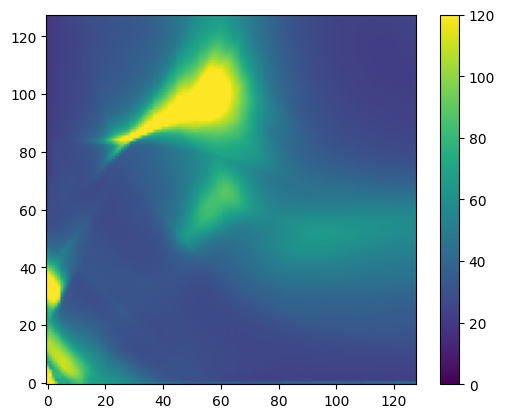

In [21]:
bar = plt.imshow(data["scatter_cube"][1180], origin="lower", vmin=0, vmax=120,)
plt.colorbar(bar)
plt.show()